In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.dates as mdates
import statsmodels.api as sm
pd.options.plotting.backend = "plotly"

### Weekday frequency analysis

In [32]:
sales1 = pd.read_pickle("../Data/total_sales_09-10_cleaned.pkl")
sales1 = sales1[sales1['date'] >= '2010-01-01']

In [33]:
sales1.head(10)

,date,weekday,hour,total_amount
206,2010-01-04,Monday,9,45.00
207,2010-01-04,Monday,10,554.58
208,2010-01-04,Monday,11,230.90
209,2010-01-04,Monday,12,2705.35
210,2010-01-04,Monday,13,7228.35
211,2010-01-04,Monday,14,635.90
212,2010-01-04,Monday,15,1237.17
213,2010-01-04,Monday,16,543.81
214,2010-01-04,Monday,17,269.48
215,2010-01-05,Tuesday,8,316.70


### Purchase Frequency

In [34]:
sales1_byWeekday = sales1.groupby('weekday', as_index = False).count()
sales1_byWeekday = sales1_byWeekday.drop(columns = ['date', 'hour'])
sales1_byWeekday = sales1_byWeekday.rename(columns = {'total_amount':'purchase_frequency'})
sales1_byWeekday.head(10)

,weekday,purchase_frequency
0,Friday,429
1,Monday,431
2,Sunday,322
3,Thursday,583
4,Tuesday,483
5,Wednesday,456


In [67]:
fig = px.histogram(sales1_byWeekday, x="weekday", 
    y='purchase_frequency', 
    color = 'weekday', 
    text_auto=True,
    labels={'purchase_frequency': 'Purchase Frequency'},
    title="Purchase Frequency by Weekday")
fig.update_xaxes(categoryorder='array', categoryarray= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.update_layout(bargap=0.2)
fig.show()

### Sales amount barplot

In [36]:
sales1_amount = sales1.drop(columns=['date', 'hour'])
sales1_amount.head(10)

,weekday,total_amount
206,Monday,45.00
207,Monday,554.58
208,Monday,230.90
209,Monday,2705.35
210,Monday,7228.35
211,Monday,635.90
212,Monday,1237.17
213,Monday,543.81
214,Monday,269.48
215,Tuesday,316.70


In [69]:
fig = px.box(sales1, x='total_amount', y='weekday', 
    color = 'weekday',
    labels={'total_amount': 'Total Amount'},
    title="Total Amount by Weekday")

fig.update_xaxes(
    range=[0,15000],  # sets the range of xaxis
)
fig.show()


### Quarter Analysis

In [52]:
def toQuarter(temp_date):
    month = str(temp_date)[5:7]
    return 'Q'+ str((int(month)-1)//3 + 1)

In [57]:
sales1['quarter'] = [toQuarter(ele) for ele in sales1['date']]
sales1_byQuarter = sales1.groupby('quarter', as_index = False).sum()
sales1_byQuarter = sales1_byQuarter.drop(columns = ['hour'])
sales1_byQuarter.head(10)

,quarter,total_amount
0,Q1,1417438.189
1,Q2,1548266.721
2,Q3,1694313.781
3,Q4,2141522.372


In [58]:
fig = px.histogram(sales1_byQuarter, x="quarter", 
    y='total_amount', 
    color = 'quarter', 
    text_auto=True,
    labels={'total_amount': 'Total Amount'})
fig.update_layout(bargap=0.2)
fig.show()

In [61]:
sales1_byQuarter = sales1.groupby('quarter', as_index = False).count()
sales1_byQuarter = sales1_byQuarter.drop(columns = ['date', 'hour', 'weekday'])
sales1_byQuarter = sales1_byQuarter.rename(columns = {'total_amount':'purchase_frequency'})
sales1_byQuarter.head(10)

,quarter,purchase_frequency
0,Q1,690
1,Q2,688
2,Q3,730
3,Q4,596


In [62]:
fig = px.histogram(sales1_byQuarter, x="quarter", 
    y='purchase_frequency', 
    color = 'quarter', 
    text_auto=True,
    labels={'purchase_frequency': 'Purchase Frequency'})
fig.update_layout(bargap=0.2)
fig.show()

In [65]:
fig = px.box(sales1, x='total_amount', y='quarter', 
    color = 'quarter')

fig.update_xaxes(
    range=[0,15000],  # sets the range of xaxis
)
fig.show()

## Pre-modeling

In [83]:
sales1_byDay = sales1.groupby('date', as_index = False).sum()
sales1_byDay = sales1_byDay.drop(columns = ['hour'])
sales1_byDay.head(10)


,date,total_amount
0,2010-01-04,13450.54
1,2010-01-05,19136.14
2,2010-01-06,8740.69
3,2010-01-07,24232.71
4,2010-01-08,24270.93
5,2010-01-10,22487.84
6,2010-01-11,14568.02
7,2010-01-12,36527.57
8,2010-01-13,9270.83
9,2010-01-14,22312.27


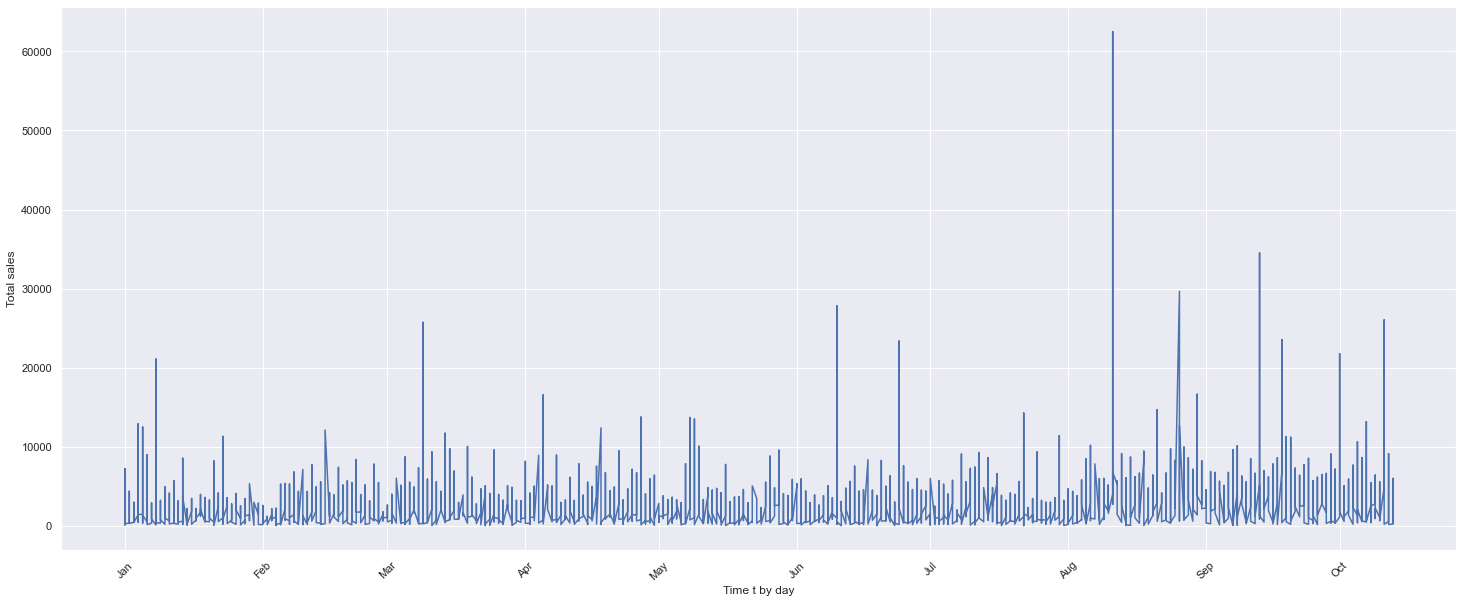

In [121]:
plt.figure(figsize=(25,10))

plt.xticks(rotation=45)
plt.plot(sales1['date'], sales1['total_amount'])
plt.ylabel('Total sales')
plt.xlabel('Time t by day')
plt.grid(True)

locator = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)
plt.show()

In [92]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### From the acf and pacf graph, we are pretty sure that at least an ARMA should be used later but the best choice of the combination of p and q is not obvious.

In [129]:
sales1.head(5)

,date,weekday,hour,total_amount,quarter
206,2010-01-04,Monday,9,45.00,Q1
207,2010-01-04,Monday,10,554.58,Q1
208,2010-01-04,Monday,11,230.90,Q1
209,2010-01-04,Monday,12,2705.35,Q1
210,2010-01-04,Monday,13,7228.35,Q1


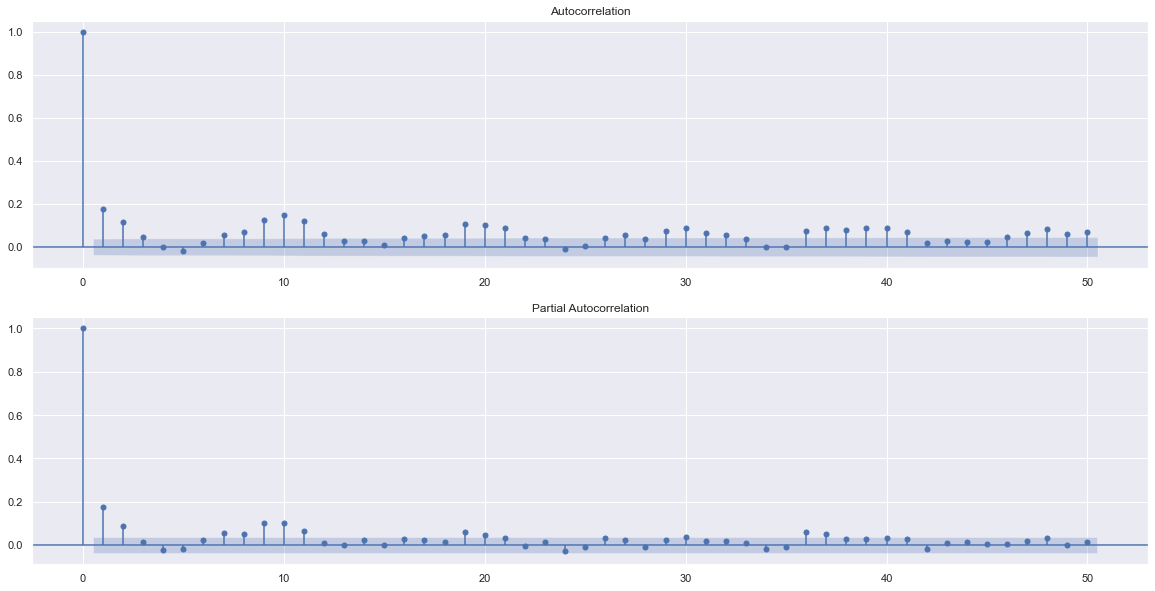

In [122]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(sales1['total_amount'], lags=50, ax = ax[0])
plot_pacf(sales1['total_amount'], lags=50, ax = ax[1])
plt.show()

In [125]:
sales1_train = sales1.iloc[:int(sales1.shape[0]*0.8)]
sales1_test = sales1.iloc[int(sales1.shape[0]*0.8):]
print('train: ', sales1_train.shape)
print('test: ', sales1_test.shape)

train:  (2163, 5)
test:  (541, 5)


In [131]:
model = sm.tsa.SARIMAX(sales1_train['total_amount'], order=(1,1,1))
results = model.fit()
print(results.summary())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30599D+00    |proj g|=  9.26180D-02

At iterate    5    f=  9.25118D+00    |proj g|=  6.83613D-03

At iterate   10    f=  9.24486D+00    |proj g|=  6.74668D-04

At iterate   15    f=  9.24480D+00    |proj g|=  1.38868D-03

At iterate   20    f=  9.23964D+00    |proj g|=  1.53227D-02

At iterate   25    f=  9.23714D+00    |proj g|=  4.74826D-02

At iterate   30    f=  9.23512D+00    |proj g|=  8.84149D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [132]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           total_amount   No. Observations:                 2163
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -19975.535
Date:                Sat, 11 Feb 2023   AIC                          39957.071
Time:                        17:40:56   BIC                          39974.107
Sample:                             0   HQIC                         39963.302
                               - 2163                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1203      0.016      7.668      0.000       0.090       0.151
ma.L1         -0.9878      0.004   -255.505      0.000      -0.995      -0.980
sigma2      6.196e+06   3.08e+04    201.403      0.000    6.14e+06    6.26e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):           2528667.58
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                             8.67
Prob(H) (two-sided):                  0.00   Kurtosis:                       169.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
results.aic

39957.070940617596

In [140]:
import itertools as it

p_min = 0
d_min = 0
q_min = 0

p_max = 5
d_max = 3
q_max = 10

col = ['AR', 'MA', "Diff", 'AIC', 'BIC']
result_frame = pd.DataFrame(columns = col)

for p, d, q in it.product(range(p_min, p_max+1), range(d_min, d_max+1), range(q_min, q_max+1)):
    if p==0 and d==0 and q==0:
        result_frame = result_frame.append(pd.Series([0,0,0,np.nan,np.nan], index = col), ignore_index=True)
        continue
    try:
        model = sm.tsa.SARIMAX(sales1_train['total_amount'], order=(p,d,q))
        results = model.fit()
        result_frame = result_frame.append(pd.Series([p,d,q,results.aic,results.bic], index = col), ignore_index=True)
        
    except:
        continue
        

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45392D+00    |proj g|=  4.32934D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.504D-05   9.453D+00
  F =   9.4530672790643315     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.4

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40360D+00    |proj g|=  9.37492D-02

At iterate    5    f=  9.39544D+00    |proj g|=  6.91706D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   6.917D-05   9.395D+00
  F =   9.3954375509027575     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40369D+00    |proj g|=  1.39068D-01

At iterate    5    f=  9.38392D+00    |proj g|=  8.26441D-05

At iterate   10    f=  9.38391D+00    |proj g|=  2.92246D-03

At iterate   15    f=  9.38274D+00    |proj g|=  3.54618D-02

At iterate   20    f=  9.36228D+00    |proj g|=  4.38383D-02

At iterate   25    f=  9.36109D+00    |proj g|=  7.49569D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.



At iterate    5    f=  9.38188D+00    |proj g|=  8.89980D-05

At iterate   10    f=  9.38186D+00    |proj g|=  4.94032D-03

At iterate   15    f=  9.37952D+00    |proj g|=  5.89485D-02

At iterate   20    f=  9.35502D+00    |proj g|=  3.29188D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     29      1     0     0   5.607D-06   9.354D+00
  F =   9.3542894362448994     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41544D+00    |proj g|=  1.73400D-01

At iterate    5    f=  9.37800D+00    |proj g|=  9.21396D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6      8      1     0     0   9.214D-05   9.378D+00
  F =   9.3779989467815650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 v

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.



At iterate    5    f=  9.37471D+00    |proj g|=  5.85512D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      8     10      1     0     0   9.286D-05   9.375D+00
  F =   9.3747109920088558     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40499D+00    |proj g|=  1.60652D-01

At iterate    5    f=  9.37315D+00    |proj g|=  2.86244D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      8     10      1     0     0   9.389D-05   9.373D+00
  F =   9.3731394556581265     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39346D+00    |proj g|=  1.45821D-01

At iterate    5    f=  9.36553D+00    |proj g|=  1.02433D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      8     10      1     0     0   9.794D-05   9.366D+00
  F =   9.3655276519153752     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38540D+00    |proj g|=  1.39998D-01

At iterate    5    f=  9.35647D+00    |proj g|=  5.37668D-04

At iterate   10    f=  9.35647D+00    |proj g|=  2.19809D-04

At iterate   15    f=  9.35644D+00    |proj g|=  3.43122D-03

At iterate   20    f=  9.35073D+00    |proj g|=  3.42551D-02

At iterate   25    f=  9.31928D+00    |proj g|=  2.43740D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     29     31      1     0     0   

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51809D+00    |proj g|=  1.39622D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.396D-07   9.518D+00
  F =   9.5180895773462382     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.3

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


At iterate   10    f=  9.24131D+00    |proj g|=  5.24853D-05

At iterate   15    f=  9.24121D+00    |proj g|=  6.06931D-04

At iterate   20    f=  9.23859D+00    |proj g|=  1.81045D-03

At iterate   25    f=  9.23580D+00    |proj g|=  2.80915D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     32      1     0     0   1.790D-06   9.236D+00
  F =   9.2358020710194868     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24464D+00    |proj g|=  6.28207D-02

At iterate    5    f=  9.24023D+00    |proj g|=  2.55900D-02

At iterate   10    f=  9.23601D+00    |proj g|=  4.89123D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   3.444D-05   9.236D+00
  F =   9.2359788157204239     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 This problem is unconstrained.



At iterate    5    f=  9.25004D+00    |proj g|=  2.40032D-02

At iterate   10    f=  9.23539D+00    |proj g|=  7.17578D-03

At iterate   15    f=  9.23454D+00    |proj g|=  1.40521D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   2.071D-05   9.235D+00
  F =   9.2345440471094538     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.59995D+00    |proj g|=  7.83267D-01


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.



At iterate    5    f=  9.25091D+00    |proj g|=  2.61370D-02

At iterate   10    f=  9.23525D+00    |proj g|=  7.51415D-03

At iterate   15    f=  9.23436D+00    |proj g|=  5.98020D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     21      1     0     0   1.826D-05   9.234D+00
  F =   9.2343584714006131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23632D+00    |proj g|=  3.81412D-02

At iterate    5    f=  9.23267D+00    |proj g|=  1.76845D-04

At iterate   10    f=  9.23266D+00    |proj g|=  3.21148D-03

At iterate   15    f=  9.23264D+00    |proj g|=  4.75156D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     17      1     0     0   4.752D-05   9.233D+00
  F =   9.2326364085226267     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23683D+00    |proj g|=  3.61993D-02

At iterate    5    f=  9.23327D+00    |proj g|=  5.63646D-04

At iterate   10    f=  9.23302D+00    |proj g|=  1.26468D-02


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23683D+00    |proj g|=  2.23394D-02

At iterate    5    f=  9.23562D+00    |proj g|=  2.70047D-04

At iterate   10    f=  9.23556D+00    |proj g|=  5.64852D-03

At iterate   15    f=  9.23413D+00    |proj g|=  3.28706D-02

At iterate   20    f=  9.23224D+00    |proj g|=  3.70846D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     21     28      1     0     0   1.353D-05   9.232D+00
  F =   9.2322364738312892     

CONVERG

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23639D+00    |proj g|=  3.38051D-02

At iterate    5    f=  9.23482D+00    |proj g|=  8.32131D-03

At iterate   10    f=  9.23202D+00    |proj g|=  1.83814D-03

At iterate   15    f=  9.23200D+00    |proj g|=  2.48169D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     15     18      1     0     0   2.482D-05   9.232D+00
  F =   9.2320046811786316     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23598D+00    |proj g|=  4.14960D-02

At iterate    5    f=  9.23410D+00    |proj g|=  1.12062D-02

At iterate   10    f=  9.23012D+00    |proj g|=  4.71791D-03

At iterate   15    f=  9.23000D+00    |proj g|=  8.48251D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     16     19      1     0     0   5.316D-05   9.230D+00
  F =   9.2300006593960209     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00507D+01    |proj g|=  1.63602D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.636D-07   1.005D+01
  F =   10.050745196834717     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.0

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.



At iterate   10    f=  9.31722D+00    |proj g|=  6.53652D-04

At iterate   15    f=  9.30755D+00    |proj g|=  1.22773D-04
  ys=-7.849E-03  -gs= 3.323E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     50      1     1     0   9.445D-04   9.246D+00
  F =   9.2462248305027224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05712D+01    |proj g|=  2.11840D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.



At iterate    5    f=  9.40020D+00    |proj g|=  6.41772D-02

At iterate   10    f=  9.30982D+00    |proj g|=  8.80726D-03

At iterate   15    f=  9.29107D+00    |proj g|=  1.93113D-02

At iterate   20    f=  9.28350D+00    |proj g|=  2.98354D-03

At iterate   25    f=  9.28089D+00    |proj g|=  1.73415D-03

At iterate   30    f=  9.28078D+00    |proj g|=  1.19713D-03

At iterate   35    f=  9.25733D+00    |proj g|=  4.49504D-02

At iterate   40    f=  9.23929D+00    |proj g|=  4.46321D-02

At iterate   45    f=  9.23529D+00    |proj g|=  8.81304D-03


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.



At iterate   50    f=  9.23505D+00    |proj g|=  2.43973D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     81      1     0     0   2.440D-03   9.235D+00
  F =   9.2350498617630361     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06834D+01    |proj g|=  2.32936D+00

At iterate    5    f=  9.39400D+00    |proj g|=  5.43910D-02

At iterate   10    f=  9.30286D+00    |proj g|=  1.27521D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  9.26550D+00    |proj g|=  1.65279D-04

At iterate   35    f=  9.26546D+00    |proj g|=  5.22113D-03

At iterate   40    f=  9.26534D+00    |proj g|=  1.52793D-04

At iterate   45    f=  9.26464D+00    |proj g|=  1.12408D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     93      2     0     0   1.240D-02   9.251D+00
  F =   9.2508121554287772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.



At iterate    5    f=  9.39501D+00    |proj g|=  5.81808D-02

At iterate   10    f=  9.29113D+00    |proj g|=  1.67653D-02

At iterate   15    f=  9.26952D+00    |proj g|=  3.62823D-02


In [138]:
result_frame.head(10)

,AR,MA,Diff,AIC,BIC
0,0.0,0.0,0.0,NaN,NaN
